# Grover-Mixer QAOA for Portfolio Optimization
In portfolio optimization, the weights $w_i$ allocated to different assets must satisfy the budget constraint $\sum_{i} w_i = 1$. We enforce this as a hard constraint by designing a Grover's algorithm that prepares a (near) uniform superposition of all feasible portfolios. Then, this constraint-projection unitary $U_{Grover}$ is transformed into the mixing operator in the GM-QAOA framework as described in [Bärtschi et al.(2020)](https://arxiv.org/abs/2006.00354).

Portfolio optimization is a multi-objective optimization problem that involves maximizing return while minimizing volatility. We approach this using the weighted-sum method, combining the two objectives with equal weights. This leaves us with a single objective to minimize:

$$\min_{w} \left( -\mu^T w + w^T \Sigma w \right)$$

for an $N$-asset portfolio $w \in [0,1]^N$, where $\mu$ represents expected returns and $\Sigma$ is the covariance matrix (representing volatility).To implement this on a quantum device, the continuous variables $w_i$ are discretized using $m$ binary bits:

$$w_i = \sum^{m}_{j=1}\frac{2^{j-1}}{2^{m}-1} \cdot w_{ij}$$

where $w_{ij} \in \{0,1\}$. This transforms the budget constraint $\sum w_i = 1$ into:$$\sum^{N}_{i=1}\sum^{m}_{j=1} 2^{j-1}w_{ij} = 2^m-1$$

The number of feasible portfolios given $N$ assets and $m$-bit resolution is calculated as:

$$n_{feasible} =  \frac{(2^m + N - 2)!}{(2^m - 1)! (N - 1)!}$$

This can be visualized as distributing $2^m - 1$ identical units of capital into $N$ distinct asset "bins" using $N-1$ dividers. For example, if we have $2^m - 1 = 7$ units and $N=3$ assets, the configuration O|OO|OOOO represents a partition of $(1, 2, 4)$, corresponding to the portfolio $(\frac{1}{7},\frac{2}{7},\frac{4}{7})$.

In [61]:
import cudaq
from cudaq import spin
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from helpers import num_feasible, ideal_iterations, generate_correlation_matrix

## 1. Generate random portfolio QUBO instance
To demonstrate the Grover-Mixer QAOA, we consider a small-scale instance with $N = 3$ assets and $m = 3$ bits of resolution per asset. This configuration requires a total of $N \times m = 9$ qubits. While the full Hilbert space contains $2^9 = 512$ possible states, only $36$ of these states are feasible under the budget constraint.

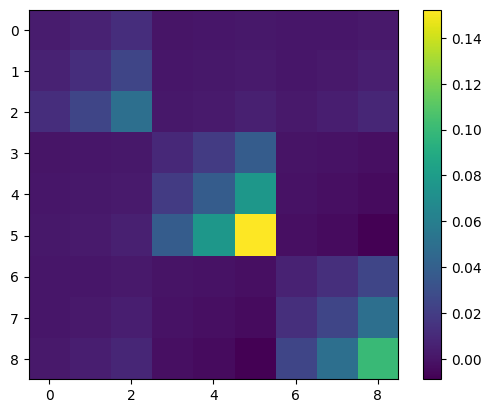

In [53]:
N = 3 # number of assets
m = 3 # 3-bit resolution (w_i = 1/7 * w_i1 + 2/7 * w_i2 + 4/7 * w_i3)

np.random.seed(42)
mean = np.random.rand(N) / 4                  # means (expected returns) of assets (0-25%)
std = pow(mean, 0.8) * (2 + np.random.rand(N))  # standard deviations of assets

corr = generate_correlation_matrix(N)
covariance = np.outer(std, std) * corr

QUBO = np.zeros((m*N,m*N))

## linear terms from return and covariance
for i in range(N):
    for k in range(m):
        QUBO[i*m+k,i*m+k] = -mean[i]*2**k/(2**m-1)
        QUBO[i*m+k,i*m+k] = covariance[i,i]*(2**k/(2**m-1))**2

## quadratic terms from covariance
for i in range(N):
    for j in range(N):
        for k in range(m):
            for s in range(m):
                if (i!=j) or (k!=s):
                    QUBO[i*m+k,j*m+s] = covariance[i,j]*2**k*2**s/(2**m-1)**2

plt.imshow(QUBO)
plt.colorbar()

We convert the QUBO objective function into the Ising basis using the transformation:

$$x_{i} = \frac{1 - Z_{i}}{2}$$

where $Z_i$ is the Pauli-Z operator. This mapping allows us to represent the portfolio optimization problem as a cost Hamiltonian $H_C$, which is then used as the phase-separation operator in the QAOA ansatz.

In [54]:
Ising = np.zeros(QUBO.shape)
for i in range(len(QUBO)):
    Ising[i,i] = -0.5*np.sum(QUBO[i,:])
    for j in range(i+1,len(QUBO)):
        Ising[i,j] = 0.25*QUBO[i,j]
        Ising[j,i] = 0.25*QUBO[j,i]

## 2. Build the Grover's oracle that marks feasible portfolios
We compute the total portfolio weights and store the sum in ancilla qubits; these ancillas serve as the control condition for the phase-flip operation that marks feasible basis states.

In [63]:
@cudaq.kernel
def budget_oracle(qvector: cudaq.qvector, N: int, m: int, num_ancilla: int):
  """
    Oracle that marks feasible basis states satisfying the budget constraint.
    
    Args:
        qvector (cudaq.qvector): The register containing working qubits and ancillas.
        N (int): Number of assets in the portfolio.
        m (int): Bit resolution per asset weight.
        num_ancilla (int): Number of ancilla qubits used for storing the sum.
    """
  num_qubits = N*m  # number of working qubits

  # apply quantum adder gates
  for i in range(N):
    for j in range(m):
      ctrl_idx = i * m + j # index of the weight variable w_ij

      swap(qvector[ctrl_idx],qvector[num_qubits+j-1])

      # xtarget: target qubit of the Toffoli gate
      for xtarget in range(num_qubits+ num_ancilla -1, num_qubits + j -1 , -1):
          x.ctrl(qvector[num_qubits+j-1 : xtarget], qvector[xtarget])

      swap(qvector[ctrl_idx],qvector[num_qubits+j-1])

  # control condition: |ancillas> = 7 = |11100> (LSB on the left)
  x(qvector[num_qubits+m:])  # controlled on |0>

  # phase-flip operator
  x.ctrl(qvector[num_qubits:],qvector[0])
  z.ctrl(qvector[num_qubits:],qvector[0])
  x.ctrl(qvector[num_qubits:],qvector[0])
  z.ctrl(qvector[num_qubits:],qvector[0])

  x(qvector[num_qubits+m:])

  # uncompute ancillas
  for i in range(N-1,-1,-1):
    for j in range(m-1,-1,-1):
      ctrl_idx = i * m + j
      swap(qvector[ctrl_idx],qvector[num_qubits+j-1])
      for xtarget in range(num_qubits + j, num_qubits+ num_ancilla):
        x.ctrl(qvector[num_qubits+j-1 : xtarget], qvector[xtarget])
      swap(qvector[ctrl_idx],qvector[num_qubits+j-1])

In [ ]:
@cudaq.kernel
def example_budget_oracle(N: int, m: int, num_ancilla: int):
    qvector = cudaq.qvector(N*m+num_ancilla)
    budget_oracle(qvector, N, m, num_ancilla)
    
print(cudaq.draw(example_budget_oracle,3,3,5))

                                                                            »
 q0 : ─╳───────────────────────────╳────────────────────────────────────────»
       │                           │                                        »
 q1 : ─┼───────────────────────────┼──╳──────────────────────╳──────────────»
       │                           │  │                      │              »
 q2 : ─┼───────────────────────────┼──┼──────────────────────┼──╳───────────»
       │                           │  │                      │  │           »
 q3 : ─┼───────────────────────────┼──┼──────────────────────┼──┼───────────»
       │                           │  │                      │  │           »
 q4 : ─┼───────────────────────────┼──┼──────────────────────┼──┼───────────»
       │                           │  │                      │  │           »
 q5 : ─┼───────────────────────────┼──┼──────────────────────┼──┼───────────»
       │                           │  │                      │  

## 3. Construct the Grover's operator $G = -AS_{0}A^{\dagger}S_{x}$
The budget oracle corresponds to the $S_x$ operator. The application of $G$ amplifies the amplitudes of the feasible states, rotating the overall quantum state toward the desired uniform superposition of all portfolios that satisfy the hard constraint.

In [66]:
@cudaq.kernel
def Grover_operator(qvector: cudaq.qvector, N: int, m: int, num_ancilla: int):
    """
    Grover's operator that amplifies the amplitudes of the feasible states 
    
    Args:
        qvector (cudaq.qvector): The register containing working qubits and ancillas.
        N (int): Number of assets in the portfolio.
        m (int): Bit resolution per asset weight.
        num_ancilla (int): Number of ancilla qubits used for storing the sum.
    """

    num_qubits = N*m

    # Sx
    budget_oracle(qvector,N,m,num_ancilla)

    # A† (inverse initial state preparation operator)
    h(qvector[:num_qubits])

    # S0
    x(qvector[:num_qubits])
    z.ctrl(qvector[:num_qubits-1],qvector[num_qubits-1])
    x(qvector[:num_qubits])

    # A
    h(qvector[:num_qubits])


## 4. Grover projection onto the feasible subspace
After constructing the Grover operator, we apply it for several iterations to concentrate the probability amplitude on the feasible states. The optimal number of iterations is approximately $\frac{\pi}{4}\sqrt{\frac{2^{Nm}}{n_{feasible}}}$, which ensures the initial state is rotated as close as possible to the target uniform superposition.

In [67]:
@cudaq.kernel
def Grover_projection(qvector: cudaq.qvector, N: int, m: int, num_ancilla: int, grover_rounds: int):
  """
    Performs Grover's algorithm to project the initial state onto the feasible 
    subspace defined by the budget constraint.
    
    Args:
        qvector (cudaq.qvector): The register containing working qubits and ancillas.
        N (int): Number of assets in the portfolio.
        m (int): Bit resolution per asset weight.
        num_ancilla (int): Number of ancilla qubits used for storing the sum.
        grover_rounds (int): The number of iterations of the Grover operator to apply.
  """
  num_qubits = N*m

  # initialization
  h(qvector[:num_qubits])

  for _ in range(grover_rounds):
    Grover_operator(qvector,N,m,num_ancilla)

Extract the feasible portfolios

In [68]:
@cudaq.kernel
def feasible_states( N: int, m: int, num_ancilla: int, grover_rounds: int):
    qvector = cudaq.qvector(N*m+num_ancilla)
    Grover_projection(qvector, N, m, num_ancilla, grover_rounds)
    mz(qvector[:N*m])

num_ancilla = math.ceil(math.log2(N*(2**m-1)))
# calculate the optimal number of Grover iterations
# we take the floor of the result to ensure a valid integer count and reduce circuit depth
grover_rounds = ideal_iterations(N,m)
result = cudaq.sample(feasible_states, N,m,num_ancilla,grover_rounds,shots_count=5000)
feasible_sols = [state for state,count in result.items() if count > 5000*(1/num_feasible(N,m))/2]
print("feasible portfolios: \n", feasible_sols)
print(f"Number of feasible portfolios: {len(feasible_sols)}")

feasible portfolios: 
 ['010001100', '000101010', '011000100', '001100010', '000100011', '010100001', '100010001', '100000011', '000010101', '010000101', '010010110', '110010010', '100110110', '001000110', '101000010', '110100110', '101010000', '110001000', '011100000', '100100101', '100101100', '111000000', '100011000', '110000001', '101100100', '010110010', '001010100', '100001010', '110110100', '000011100', '001110000', '010101000', '000111000', '000000111', '000110001', '000001110']
Number of feasible portfolios: 36


Evaluate the objective function across all feasible portfolios to find the classical optimum.

In [ ]:
def Ising_cost(Ising: list[list[float]],x: list[int|float] | tuple[int|float]):
    """
    Ising: The Ising matrix
    x: The Ising vector {-1,1} used to evaluate the cost value.
    """
    linear = np.dot(np.diag(Ising),x)
    quadratic = np.sum([Ising[i,j]*x[i]*x[j] for i in range(len(x)) for j in range(i+1, len(x))])
    return linear + quadratic

# Find out the optimal portfolio given the chosen resolution.
best = None
best_value = 0
for sol in feasible_sols:
    ising_sol =  [1 if s=="0" else -1 for s in sol]
    cost = Ising_cost(Ising, ising_sol)
    if best is None:
        best = ising_sol
        best_value = cost
    elif cost < best_value:
        best = ising_sol
        best_value = cost

best_qubo = [1 if b==-1 else 0 for b in best]
print("best portfolio: ", best_qubo)
print("minimum cost: ", best_value)

best portfolio:  [0, 1, 1, 0, 0, 0, 1, 0, 0]
minimum cost:  -0.24050510949303733


## 5. Grover-Mixer QAOA Ansatz
We construct the GM-QAOA ansatz by defining the mixing operator $U_M(\beta)$ based on the constraint-projection unitary $U_{Grover}$. The mixer $U_M(\beta)$ is composed of a parametrized phase-shift operator on the all-zero state $\ket{0}^{\otimes n}$, sandwiched between $U_{Grover}$ and its adjoint $U_{Grover}^\dagger$:

$$U_M(\beta) = U_{Grover}^\dagger \cdot R_0(\beta) \cdot U_{Grover}$$

where $R_0(\beta) = I - (1 - e^{i\beta})\ket{0}\bra{0}$ is the phase-shift operator.

In [69]:
@cudaq.kernel
def GM_QAOA(N: int, m: int, num_ancilla: int, grover_rounds: int,
      Ising_flat: list[float], num_layers: int, params: list[float]):
    num_qubits = N*m
    qvector = cudaq.qvector(num_qubits+num_ancilla)

    mixer_params = params[: num_layers]
    cost_params = params[num_layers:]

    # initial state
    Grover_projection(qvector, N, m, num_ancilla, grover_rounds)

    # alternating cost and mixer
    for layer in range(num_layers):

        # cost unitary
        for i in range(num_qubits):
            idx = i * num_qubits + i
            rz(2 * cost_params[layer] * Ising_flat[idx], qvector[i])
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                idx = i * num_qubits + j
                if Ising_flat[idx] != 0.0:
                    theta = 2 * cost_params[layer] * Ising_flat[idx]
                    # RZZ = CX-RZ-CX
                    x.ctrl(qvector[i], qvector[j])
                    rz(theta, qvector[j])
                    x.ctrl(qvector[i], qvector[j])

        # mixer unitary
        # inverse constraint projection unitary
        cudaq.adjoint(Grover_projection, qvector, N, m, num_ancilla, grover_rounds)
        x(qvector[:num_qubits])
        # parametrized controlled-phase shift
        r1.ctrl(mixer_params[layer], qvector[:num_qubits-1],qvector[num_qubits-1])
        x(qvector[:num_qubits])
        Grover_projection(qvector, N, m, num_ancilla, grover_rounds)

## visualize the ansatz
#num_ancilla = math.ceil(math.log2(N*(2**m-1)))
#grover_rounds = ideal_iterations(N,m)
#Ising_flat = Ising.flatten()
#num_layers = 2
#initial_params = np.random.uniform(-np.pi,np.pi,2*num_layers)
#print(cudaq.draw(GM_QAOA, N, m, num_ancilla, grover_rounds, Ising_flat, num_layers, initial_params))

Wrapper kernel for measuring the circuit

In [14]:
@cudaq.kernel
def GM_QAOA_measured(N: int, m: int, num_ancilla: int, grover_rounds: int,
          Ising_flat: list[float], num_layers: int, params: list[float]):
    num_qubits = N*m
    qvector = cudaq.qvector(num_qubits+num_ancilla)

    mixer_params = params[: num_layers]
    cost_params = params[num_layers:]

    Grover_projection(qvector, N, m, num_ancilla, grover_rounds)

    for layer in range(num_layers):
        for i in range(num_qubits):
            idx = i * num_qubits + i
            rz(2 * cost_params[layer] * Ising_flat[idx], qvector[i])
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                idx = i * num_qubits + j
                if Ising_flat[idx] != 0.0:
                    theta = 2 * cost_params[layer] * Ising_flat[idx]
                    x.ctrl(qvector[i], qvector[j])
                    rz(theta, qvector[j])
                    x.ctrl(qvector[i], qvector[j])
        cudaq.adjoint(Grover_projection, qvector, N, m, num_ancilla, grover_rounds)
        x(qvector[:num_qubits])
        r1.ctrl(mixer_params[layer], qvector[:num_qubits-1],qvector[num_qubits-1])
        x(qvector[:num_qubits])
        Grover_projection(qvector, N, m, num_ancilla, grover_rounds)
    mz(qvector[:num_qubits])

## 6. Optimize the QAOA Parameters
We utilize the COBYLA (or other SciPy-based) optimizer to classically update the variational parameters. The objective is to minimize the expectation value of the cost Hamiltonian $H_C$ relative to the QAOA state.

In [15]:
def run_QAOA(N: int, m: int, Ising: list[list[float]],
             num_layers: int, optimization_method="COBYLA"):

    num_ancilla = math.ceil(math.log2(N*(2**m-1)))
    grover_rounds = ideal_iterations(N,m)
    Ising_flat = Ising.flatten()
    initial_params = np.random.uniform(-np.pi,np.pi,2*num_layers)

    # construct the cost Hamiltonian
    hamiltonian = 0
    for i in range(N*m):
        hamiltonian += Ising[i,i] * spin.z(i)
        for j in range(i+1, m):
            hamiltonian += Ising[i,j] *spin.z(i) * spin.z(j)

    # define cost function
    def cost(params):

        exp_val = cudaq.observe(GM_QAOA, hamiltonian, N, m, num_ancilla, grover_rounds, Ising_flat, num_layers, params).expectation()

        return exp_val

    # optimize the circuit using the chosen classical optimizer
    result = minimize(cost, initial_params ,method=optimization_method, options={'maxiter': 100},tol=1e-3)

    optimal_value = result.fun
    optimal_params = result.x

    print(f"Expectation value: {optimal_value:4f}")
    print(f"Optimal mixer coefficients: {optimal_params[:num_layers]}")
    print(f"Optimal cost coefficients: {optimal_params[num_layers:]}")


    # measure the circuit
    measure = cudaq.sample(GM_QAOA_measured, N, m, num_ancilla, grover_rounds, Ising_flat, num_layers, optimal_params, shots_count=10000)
    most_probable = measure.most_probable()
    probability = measure.probability(most_probable)

    # convert output to Ising basis
    vector = [1 if s=="0" else -1 for s in most_probable]
    cost_value = Ising_cost(Ising, vector)

    print(f"\nMost probable state: {most_probable} (probability: {probability:.4f})")
    print(f"Most probable state cost value: {cost_value:.4f}")
    print(f"Theoretical minimum: {best_value:.4f}")

    return optimal_params, measure

optimal_params, result = run_QAOA(N,m,Ising,num_layers=3)


Expectation value: -0.206702
Optimal mixer coefficients: [-1.24645794 -2.37843816  1.6640825 ]
Optimal cost coefficients: [-4.68418568 -3.21438315  2.65773767]

Most probable state: 011000100 (probability: 0.0651)
Most probable state cost value: -0.2405
Theoretical minimum: -0.2405


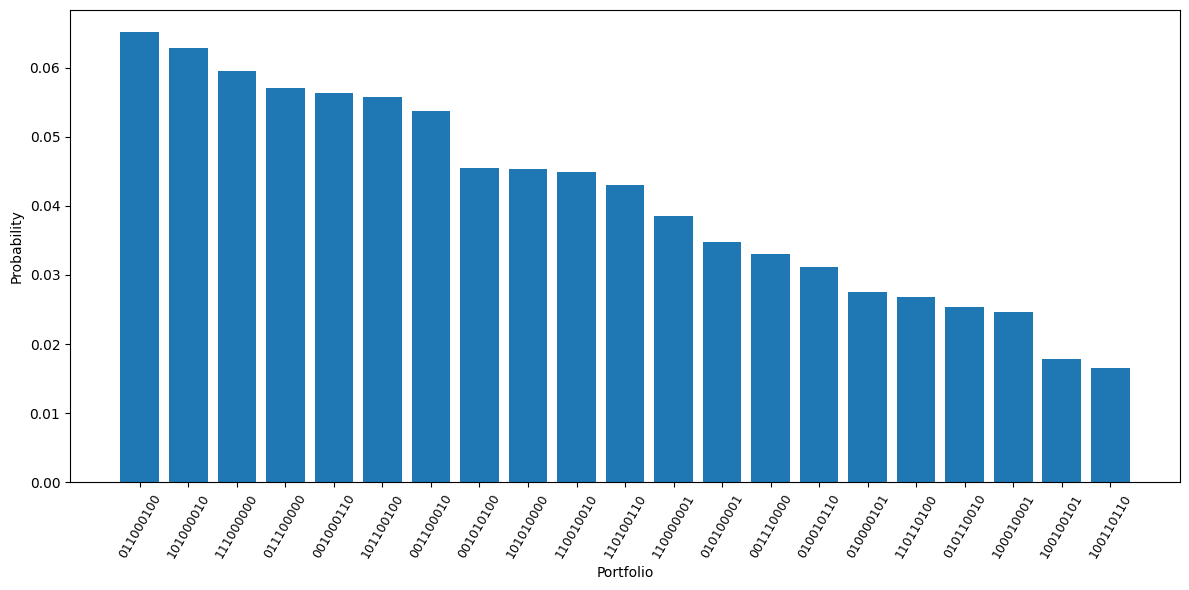

In [ ]:
top_result = {k: v/10000 for k, v in result.items() if v > 10000 * (1 / num_feasible(N, m)) / 2}

# Sort by count: highest to lowest
sorted_result = sorted(top_result.items(), key=lambda x: x[1], reverse=True)

bitstrings = [item[0] for item in sorted_result]
counts = [item[1] for item in sorted_result]

plt.figure(figsize=(12, 6)) 
plt.bar(bitstrings, counts)

plt.xticks(rotation=60, fontsize=9)
plt.xlabel('Portfolio')
plt.ylabel('Probability')

plt.tight_layout()

As illustrated in the probability distribution, the GM-QAOA successfully amplifies the amplitudes of feasible portfolios associated with lower cost values. This demonstrates that the mixer effectively explores the constrained search space to concentrate probability on the optimal and near-optimal asset allocations.